# 1. Import and Install Dependencies

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping
from keras import layers
from keras.applications import VGG16
from keras.preprocessing import image_dataset_from_directory
from keras import models
from keras import layers
from tensorflow.python.client import device_lib 


In [2]:
# Check GPU
# print(device_lib.list_local_devices())

# print(tf.config.list_physical_devices('GPU'))

# print(tf.__version__)
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available")
    device = '/GPU:0'
else:
    print("GPU not available, using CPU instead")
    device = '/CPU:0'


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU not available, using CPU instead


# 2. Load Data

In [3]:
dataset_path1 = r"../AllData/Characters/Peter/Characters_Dataset/"
dataset_path2 = r"../AllData/Characters/Aya/Characters_Dataset/"

In [4]:
classes = [ 'aleff',  'bb', 'ta', 'thaa', 'jeem', 'haa', 'khaa', 'dal', 'thal', 'ra', 
         'zay' , 'seen', 'sheen',  'saad', 'dhad','taa', 'dha', 'ain', 'ghain','fa', 
          'gaaf', 'kaaf','laam', 'meem', 'nun', 'ha', 'waw','ya']

### Prepare Data for VGG16

In [5]:
dataset1= image_dataset_from_directory(dataset_path1,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224,224),
                                             color_mode='rgb',
                                             label_mode= 'categorical',
                                             class_names=classes
                                             )

dataset2= image_dataset_from_directory(dataset_path2,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224,224),
                                             color_mode='rgb',
                                             label_mode= 'categorical',
                                             class_names=classes
                                             )

Found 2800 files belonging to 28 classes.
Found 2800 files belonging to 28 classes.


In [6]:
# Combine 2 Datasets
dataset = dataset1.concatenate(dataset2)
# Get No. of Batches
tf.data.experimental.cardinality(dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=176>

In [7]:
# Split to Training and Validation
dataset_batches = tf.data.experimental.cardinality(dataset)
# 30% of Data To Validation and Testing
validation_dataset = dataset.take(dataset_batches // 7)
# 70% of Data To Training
training_dataset = dataset.skip(dataset_batches // 7) 


In [8]:
# Split the Validation to valid and test
val_batches = tf.data.experimental.cardinality(validation_dataset)
testing_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)


In [9]:
# To Increase up Feeding Data To Network
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
# Display The No. of Batches 
print(tf.data.experimental.cardinality(training_dataset))
print(tf.data.experimental.cardinality(validation_dataset))
print(tf.data.experimental.cardinality(testing_dataset))

tf.Tensor(151, shape=(), dtype=int64)
tf.Tensor(13, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)


# 3. Initialize Data Augmentation Layer

In [11]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [12]:
# Custom Layer for Brightness and Contrast
class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.6, 1.8], 
                 brightness_delta=[-0.3, 0.3], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=True):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 255)
        return images

In [13]:
# Augmentation Layer
data_augmentation = tf.keras.Sequential([
    # Make a Random Rotation
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
    # Make a Random Width
    tf.keras.layers.RandomWidth((-.2,.2), interpolation='bilinear'),
    # Make a Random Height
    tf.keras.layers.RandomHeight((-.2,.2), interpolation='bilinear'),
    # Make a Random Translation
    tf.keras.layers.RandomTranslation((-0.1, 0.1),(-0.1, 0.1),fill_mode='constant'),
    # Resize image to 224 x 224 pixels again after Widthing,Heighting
    tf.keras.layers.Resizing(224,224,interpolation='bilinear'),
    # Make a Random Color
    RandomColorDistortion()
])

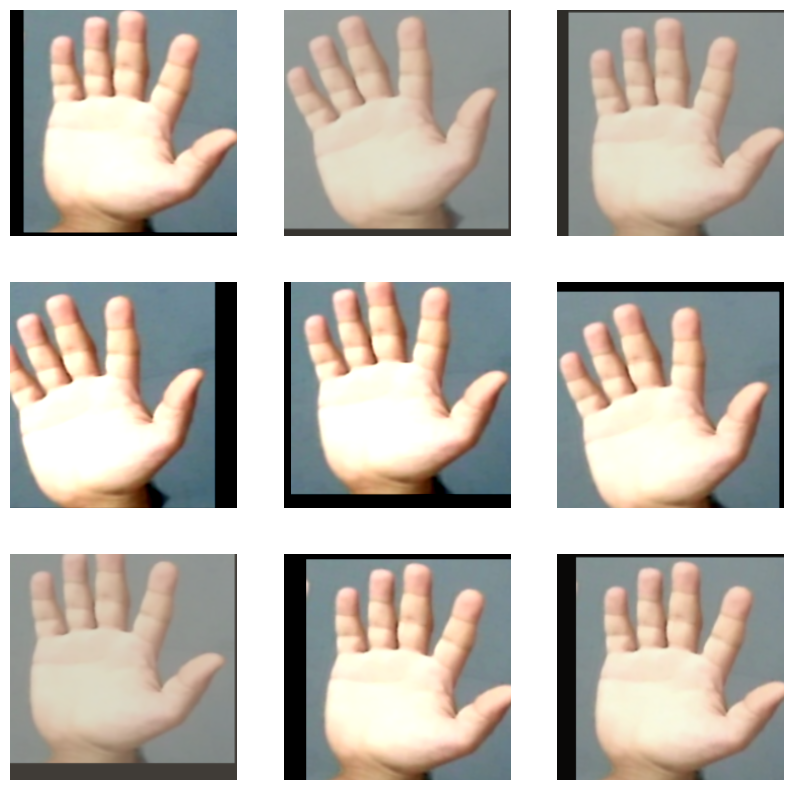

In [14]:
# Show The Output of Augmentation Layer for Same Image
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))

    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [15]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

# 4. Model VGG16

In [16]:
# Get The Base Network
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [17]:
# Freeze Conv Layer
conv_base.trainable = False

##### Build a Network for Training

In [18]:
# Build a Network for Training 
inp = layers.Input(shape=(224,224,3))
x = data_augmentation(inp)
x = (conv_base)(inp)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outs = layers.Dense(len(classes), activation='softmax')(x)
model = models.Model(inputs=inp, outputs=[outs])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 28)                3612      
                                                                 
Total params: 17929692 (68.40 MB)
Trainable params: 3215004 (12.26 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [21]:
log_dir = os.path.join('Logs/vgg16_transfer_learning')
tb_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,
                          update_freq='epoch',
                          profile_batch=0) ## !tensorboard --logdir=.
mc = ModelCheckpoint('Models/vgg16_transfer_learning.h5', monitor='val_acc', mode='max', verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1,patience=5)
callbacks = [tb_callback,mc,es]

In [22]:
model.fit(training_dataset,epochs=50,callbacks=[callbacks], validation_data = validation_dataset)
# epoch=50

Epoch 1/50
151/151 [==============================] - ETA: 0s - loss: 1.3017 - acc: 0.8256
Epoch 1: val_acc improved from -inf to 0.96154, saving model to Models\vgg16_transfer_learning.h5
151/151 [==============================] - 344s 2s/step - loss: 1.3017 - acc: 0.8256 - val_loss: 0.1435 - val_acc: 0.9615
Epoch 2/50


c:\Users\Moussa\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - ETA: 0s - loss: 0.0053 - acc: 0.9983
Epoch 2: val_acc improved from 0.96154 to 0.99038, saving model to Models\vgg16_transfer_learning.h5
151/151 [==============================] - 351s 2s/step - loss: 0.0053 - acc: 0.9983 - val_loss: 0.0174 - val_acc: 0.9904
Epoch 3/50
151/151 [==============================] - ETA: 0s - loss: 4.9232e-04 - acc: 0.9998
Epoch 3: val_acc improved from 0.99038 to 1.00000, saving model to Models\vgg16_transfer_learning.h5
151/151 [==============================] - 351s 2s/step - loss: 4.9232e-04 - acc: 0.9998 - val_loss: 4.5676e-04 - val_acc: 1.0000
Epoch 4/50
151/151 [==============================] - ETA: 0s - loss: 1.0393e-05 - acc: 1.0000
Epoch 4: val_acc did not improve from 1.00000
151/151 [==============================] - 349s 2s/step - loss: 1.0393e-05 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 0.9976
Epoch 5/50
151/151 [==============================] - ETA: 0s - loss: 3.8850e-05 - acc: 1.0000
Epoch 5: 

In [23]:
# Save The Last Model
model.save('Models/last_training_model.h5')

## 4.1 Model Evaluation

In [24]:
model.evaluate(testing_dataset) 

12/12 [==============================] - 26s 2s/step - loss: 1.3966e-04 - acc: 1.0000


[0.00013965564721729606, 1.0]